# Negative Binomial Regression for Overdispersed Count Data

**Tutorial 02 - Count Models Series**

---

## Learning Objectives

By the end of this tutorial, you will be able to:

1. Understand **overdispersion** and why it matters
2. Recognize when Negative Binomial is preferred over Poisson
3. Estimate NB1 and NB2 models using PanelBox
4. Perform formal tests for overdispersion
5. Compare Poisson and Negative Binomial models
6. Interpret the dispersion parameter (α)

---

## Prerequisites

- Completion of Tutorial 01 (Poisson Introduction)
- Understanding of variance and overdispersion concepts
- Familiarity with likelihood ratio tests

**Estimated Duration:** 60 minutes

---

## Table of Contents

1. [The Overdispersion Problem](#1-overdispersion)
2. [Negative Binomial Distribution](#2-distribution)
3. [NB1 vs NB2 Models](#3-nb1-nb2)
4. [Estimation and Comparison](#4-estimation)
5. [Testing for Overdispersion](#5-testing)
6. [Model Selection](#6-selection)
7. [Summary](#7-summary)

## Setup and Data Loading

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# PanelBox imports
from panelbox.models.count import PooledPoisson, NegativeBinomial

# Configuration
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)
np.random.seed(42)

# Paths
DATA_PATH = Path('../data')
OUTPUT_PATH = Path('../outputs')
FIGURES_PATH = OUTPUT_PATH / 'figures' / '02_negbin_solutions'
TABLES_PATH = OUTPUT_PATH / 'tables' / '02_negbin_solutions'

# Create directories
FIGURES_PATH.mkdir(parents=True, exist_ok=True)
TABLES_PATH.mkdir(parents=True, exist_ok=True)

print("Setup complete!")

Setup complete!


### Load Firm Patent Data

In [2]:
# Load data
df = pd.read_csv(DATA_PATH / 'firm_patents.csv')

print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
display(df.head(10))

print("\nDescriptive Statistics:")
display(df.describe())

# Check panel structure
print("\nPanel Structure:")
print(f"Number of firms: {df['firm_id'].nunique()}")
print(f"Number of years: {df['year'].nunique()}")
print(f"Years: {sorted(df['year'].unique())}")

Dataset Shape: (7500, 7)

First few rows:


,firm_id,year,patents,rd_expenditure,firm_size,industry,region
0,1,2015,7,36.8059,5.2139,3,4
1,1,2016,1,17.0078,2.8008,3,4
2,1,2017,14,6.9986,5.6872,3,4
3,1,2018,5,8.8718,2.0000,3,4
4,1,2019,11,46.5084,5.8802,3,4
5,2,2015,1,2.2469,3.2508,3,4
6,2,2016,9,6.1474,4.7424,3,4
7,2,2017,14,26.3990,4.4513,3,4
8,2,2018,12,89.8849,2.2978,3,4
9,2,2019,2,13.6825,5.1503,3,4



Descriptive Statistics:


,firm_id,year,patents,rd_expenditure,firm_size,industry,region
count,7500.0000,7500.0000,7500.0000,7500.0000,7500.0000,7500.0000,7500.000
mean,750.5000,2017.0000,5.5837,22.3857,5.0205,5.4887,2.990
std,433.0415,1.4143,8.0879,25.4931,1.4768,2.8741,1.395
min,1.0000,2015.0000,0.0000,0.1211,2.0000,1.0000,1.000
25%,375.7500,2016.0000,1.0000,5.4546,3.9923,3.0000,2.000
50%,750.5000,2017.0000,3.0000,12.4067,5.0380,5.0000,3.000
75%,1125.2500,2018.0000,7.0000,27.9153,6.0294,8.0000,4.000
max,1500.0000,2019.0000,45.0000,100.0000,9.0000,10.0000,5.000



Panel Structure:
Number of firms: 1500
Number of years: 5
Years: [np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019)]


## 1. The Overdispersion Problem {#1-overdispersion}

### What is Overdispersion?

**Poisson assumption**: $E[Y] = \text{Var}(Y) = \lambda$

**Overdispersion**: $\text{Var}(Y) > E[Y]$

### Causes of Overdispersion

1. **Unobserved heterogeneity**: Firms differ in ways we don't measure
2. **Excess zeros**: More zeros than Poisson predicts
3. **Event dependence**: Events are not independent
4. **Model misspecification**: Missing important covariates

### Consequences

- **Poisson standard errors too small** → over-rejection of null hypotheses
- **Incorrect inference** → falsely significant results
- **Poor model fit**

CHECKING FOR OVERDISPERSION
Mean patents: 5.5837
Variance patents: 65.4149
Variance/Mean ratio: 11.7153

Interpretation: 11.72 >> 1
→ SEVERE OVERDISPERSION detected!


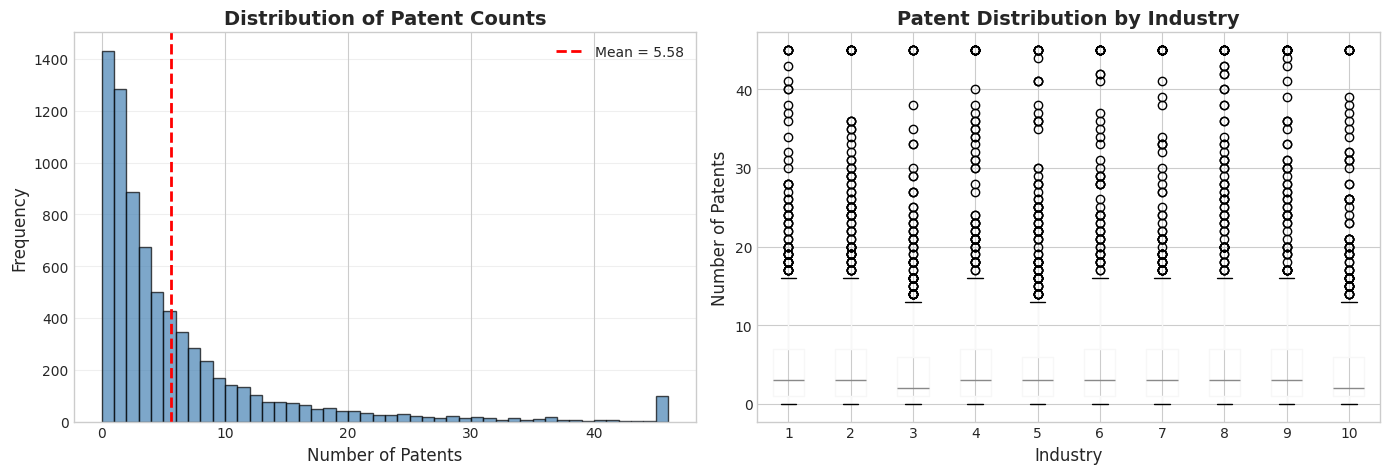

In [3]:
# Examine variance-mean relationship
print("="*60)
print("CHECKING FOR OVERDISPERSION")
print("="*60)
print(f"Mean patents: {df['patents'].mean():.4f}")
print(f"Variance patents: {df['patents'].var():.4f}")
print(f"Variance/Mean ratio: {df['patents'].var() / df['patents'].mean():.4f}")
print(f"\nInterpretation: {df['patents'].var() / df['patents'].mean():.2f} >> 1")
print("→ SEVERE OVERDISPERSION detected!")
print("="*60)

# Visualize distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df['patents'], bins=range(0, df['patents'].max()+2),
             edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(df['patents'].mean(), color='red', linestyle='--', 
                linewidth=2, label=f'Mean = {df["patents"].mean():.2f}')
axes[0].set_xlabel('Number of Patents', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Patent Counts', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Boxplot by industry
df.boxplot(column='patents', by='industry', ax=axes[1])
axes[1].set_xlabel('Industry', fontsize=12)
axes[1].set_ylabel('Number of Patents', fontsize=12)
axes[1].set_title('Patent Distribution by Industry', fontsize=14, fontweight='bold')
plt.suptitle('')  # Remove default title

plt.tight_layout()
plt.savefig(FIGURES_PATH / '01_patent_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

### Variance-Mean Plot by Firm

Let's examine if variance increases with mean across firms:

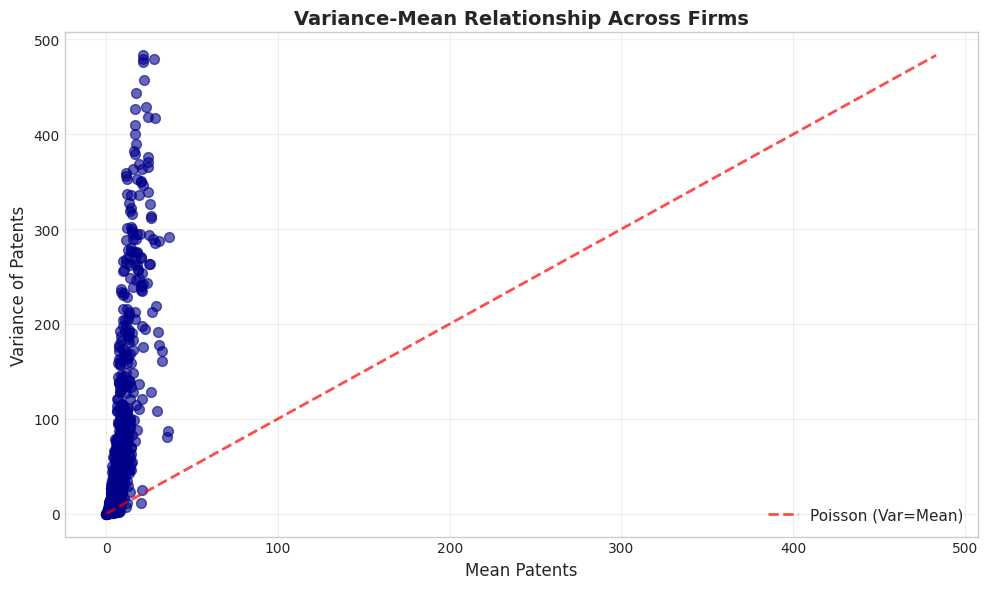


Most points are ABOVE the red line → Overdispersion!


In [4]:
# Calculate mean and variance by firm
firm_stats = df.groupby('firm_id')['patents'].agg(['mean', 'var']).reset_index()

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(firm_stats['mean'], firm_stats['var'], alpha=0.6, s=50, color='darkblue')

# Add reference line: Var = Mean (Poisson)
max_val = max(firm_stats['mean'].max(), firm_stats['var'].max())
ax.plot([0, max_val], [0, max_val], 'r--', linewidth=2, 
        label='Poisson (Var=Mean)', alpha=0.7)

ax.set_xlabel('Mean Patents', fontsize=12)
ax.set_ylabel('Variance of Patents', fontsize=12)
ax.set_title('Variance-Mean Relationship Across Firms', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_PATH / '02_variance_mean_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nMost points are ABOVE the red line → Overdispersion!")

## 2. Negative Binomial Distribution {#2-distribution}

### The Solution: Add a Dispersion Parameter

The Negative Binomial (NB) distribution extends Poisson by adding heterogeneity.

**Intuition**: Model Poisson rate $\lambda_i$ as random:

$$\lambda_i \sim \text{Gamma}(\mu_i, \alpha)$$

where:
- $\mu_i = \exp(X_i \beta)$ is the mean
- $\alpha$ is the **dispersion parameter**

### Variance Function

$$\text{Var}(Y_i) = \mu_i + \alpha \cdot g(\mu_i)$$

The function $g(\mu_i)$ determines the variance-mean relationship:
- **NB1**: $g(\mu_i) = \mu_i$ → linear
- **NB2**: $g(\mu_i) = \mu_i^2$ → quadratic (most common)

### Special Cases

- When $\alpha = 0$: NB reduces to Poisson
- When $\alpha > 0$: Overdispersion present

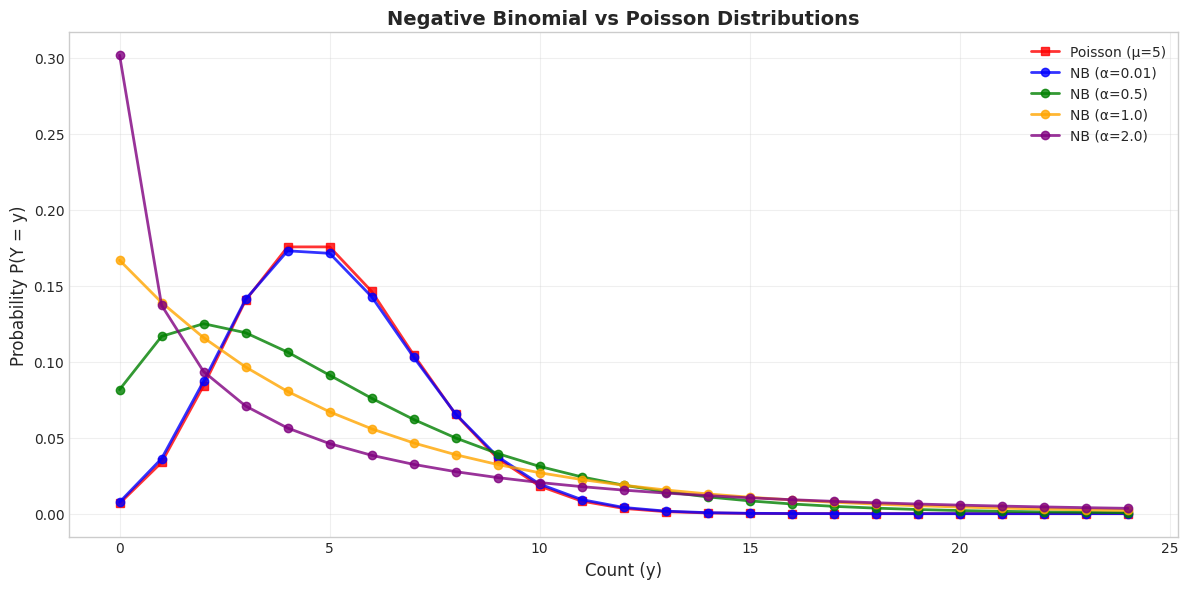

In [5]:
# Visualize NB distributions
mu = 5
alphas = [0.01, 0.5, 1.0, 2.0]
x_vals = np.arange(0, 25)

fig, ax = plt.subplots(figsize=(12, 6))

# Poisson baseline
poisson_pmf = stats.poisson.pmf(x_vals, mu)
ax.plot(x_vals, poisson_pmf, marker='s', linestyle='-', linewidth=2,
        markersize=6, label=f'Poisson (μ={mu})', alpha=0.8, color='red')

# Negative Binomial with varying alpha
colors = ['blue', 'green', 'orange', 'purple']
for alpha, color in zip(alphas, colors):
    # NB2 parametrization: n = mu/alpha, p = 1/(1+alpha)
    n = 1/alpha if alpha > 0 else 1000
    p = 1/(1 + alpha*mu)
    nb_pmf = stats.nbinom.pmf(x_vals, n, p)
    ax.plot(x_vals, nb_pmf, marker='o', linestyle='-', linewidth=2,
            markersize=6, label=f'NB (α={alpha})', alpha=0.8, color=color)

ax.set_xlabel('Count (y)', fontsize=12)
ax.set_ylabel('Probability P(Y = y)', fontsize=12)
ax.set_title('Negative Binomial vs Poisson Distributions', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_PATH / '03_nb_vs_poisson.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. NB1 vs NB2 Models {#3-nb1-nb2}

### NB1 (Linear Variance)

$$\text{Var}(Y_i) = \mu_i(1 + \alpha)$$

- Variance increases **linearly** with mean
- Less common in practice

### NB2 (Quadratic Variance)

$$\text{Var}(Y_i) = \mu_i(1 + \alpha \mu_i)$$

- Variance increases **quadratically** with mean
- **Most commonly used** (Cameron & Trivedi, 2013)
- Default in most software

### Which to Choose?

- Use **AIC/BIC** to compare
- If unsure, start with **NB2**

## 4. Estimation and Comparison {#4-estimation}

Let's estimate three models:
1. Poisson (baseline)
2. Negative Binomial NB2
3. Compare results

In [6]:
import statsmodels.api as sm

# Prepare data
y = df['patents'].values
X_raw = df[['rd_expenditure', 'firm_size', 'industry', 'region']].values
X = sm.add_constant(X_raw)
entity_id = df['firm_id'].values

print("Estimating models...\n")

# 1. Poisson Model (pass entity_id for cluster-robust SE)
print("1. Fitting Poisson model...")
poisson_model = PooledPoisson(endog=y, exog=X, entity_id=entity_id)
poisson_results = poisson_model.fit(se_type='cluster')
print("   ✓ Poisson completed")

# 2. Negative Binomial Model (pass entity_id so internal Poisson init can cluster)
print("2. Fitting Negative Binomial model...")
nb_model = NegativeBinomial(endog=y, exog=X, entity_id=entity_id)
nb_results = nb_model.fit()
print("   ✓ Negative Binomial completed")

print("\nAll models estimated successfully!")

Estimating models...

1. Fitting Poisson model...


   ✓ Poisson completed
2. Fitting Negative Binomial model...


   ✓ Negative Binomial completed

All models estimated successfully!


### Compare Model Summaries

In [7]:
print("="*80)
print("POISSON MODEL RESULTS")
print("="*80)
print(poisson_results.summary())

print("\n" + "="*80)
print("NEGATIVE BINOMIAL MODEL RESULTS")
print("="*80)
# Print NB results manually to avoid internal lr_test bug in summary()
print(f"Number of Obs: {len(nb_model.endog)}")
print(f"Log-Likelihood: {nb_results.llf:.4f}")
print(f"Overdispersion (alpha): {nb_results.alpha:.4f}")
print("\nParameters:")
nb_beta_params = nb_results.params[:-1]  # exclude log_alpha
nb_se_params = nb_results.se[:-1]
nb_t_params = nb_results.tvalues[:-1]
nb_p_params = nb_results.pvalues[:-1]
for i in range(len(nb_beta_params)):
    print(f"  Param {i}: {nb_beta_params[i]:.4f} (SE: {nb_se_params[i]:.4f}, t: {nb_t_params[i]:.2f}, p: {nb_p_params[i]:.4f})")
print(f"  log_alpha: {nb_results.params[-1]:.4f} (alpha = {np.exp(nb_results.params[-1]):.4f})")

POISSON MODEL RESULTS

Model Results
Number of Obs: 7500
Number of Parameters: 5

Parameter Estimates:
-------------------
  Param 0: -0.2581 (SE: 0.0941, t: -2.74, p: 0.0061)
  Param 1: 0.0125 (SE: 0.0004, t: 29.38, p: 0.0000)
  Param 2: 0.2921 (SE: 0.0102, t: 28.77, p: 0.0000)
  Param 3: 0.0030 (SE: 0.0079, t: 0.38, p: 0.7040)
  Param 4: 0.0209 (SE: 0.0174, t: 1.20, p: 0.2289)


NEGATIVE BINOMIAL MODEL RESULTS
Number of Obs: 7500
Log-Likelihood: -26075.5203
Overdispersion (alpha): 0.1000

Parameters:
  Param 0: -0.2581 (SE: 0.0276, t: -9.35, p: 0.0000)
  Param 1: 0.0125 (SE: 0.0002, t: 57.36, p: 0.0000)
  Param 2: 0.2921 (SE: 0.0042, t: 68.95, p: 0.0000)
  Param 3: 0.0030 (SE: 0.0022, t: 1.36, p: 0.1723)
  Param 4: 0.0209 (SE: 0.0045, t: 4.61, p: 0.0000)
  log_alpha: -2.3026 (alpha = 0.1000)


### Extract and Compare Coefficients

In [8]:
# Create comparison table
var_names = ['const', 'rd_expenditure', 'firm_size', 'industry', 'region']

comparison_df = pd.DataFrame({
    'Variable': var_names,
    'Poisson_Coef': poisson_results.params,
    'Poisson_SE': poisson_results.se,
    'Poisson_pval': poisson_results.pvalues,
    'NB_Coef': nb_results.params[:5],  # First 5 are coefficients
    'NB_SE': nb_results.se[:5],
    'NB_pval': nb_results.pvalues[:5]
})

# Calculate IRRs
comparison_df['Poisson_IRR'] = np.exp(comparison_df['Poisson_Coef'])
comparison_df['NB_IRR'] = np.exp(comparison_df['NB_Coef'])

# Save table
comparison_df.to_csv(TABLES_PATH / 'table_01_model_comparison.csv', index=False)

print("\nMODEL COMPARISON TABLE")
print("="*100)
display(comparison_df[['Variable', 'Poisson_Coef', 'Poisson_SE', 'NB_Coef', 'NB_SE']])

print("\nINCIDENCE RATE RATIOS (IRRs)")
print("="*100)
display(comparison_df[['Variable', 'Poisson_IRR', 'NB_IRR']])


MODEL COMPARISON TABLE


,Variable,Poisson_Coef,Poisson_SE,NB_Coef,NB_SE
0,const,-0.2581,0.0941,-0.2581,0.0276
1,rd_expenditure,0.0125,0.0004,0.0125,0.0002
2,firm_size,0.2921,0.0102,0.2921,0.0042
3,industry,0.0030,0.0079,0.0030,0.0022
4,region,0.0209,0.0174,0.0209,0.0045



INCIDENCE RATE RATIOS (IRRs)


,Variable,Poisson_IRR,NB_IRR
0,const,0.7725,0.7725
1,rd_expenditure,1.0126,1.0126
2,firm_size,1.3392,1.3392
3,industry,1.0030,1.0030
4,region,1.0211,1.0211


### Key Observation

Notice that:
- **Coefficients are similar** between Poisson and NB
- **Standard errors are larger in NB** (correctly accounting for overdispersion)
- **Some variables significant in Poisson may not be in NB**

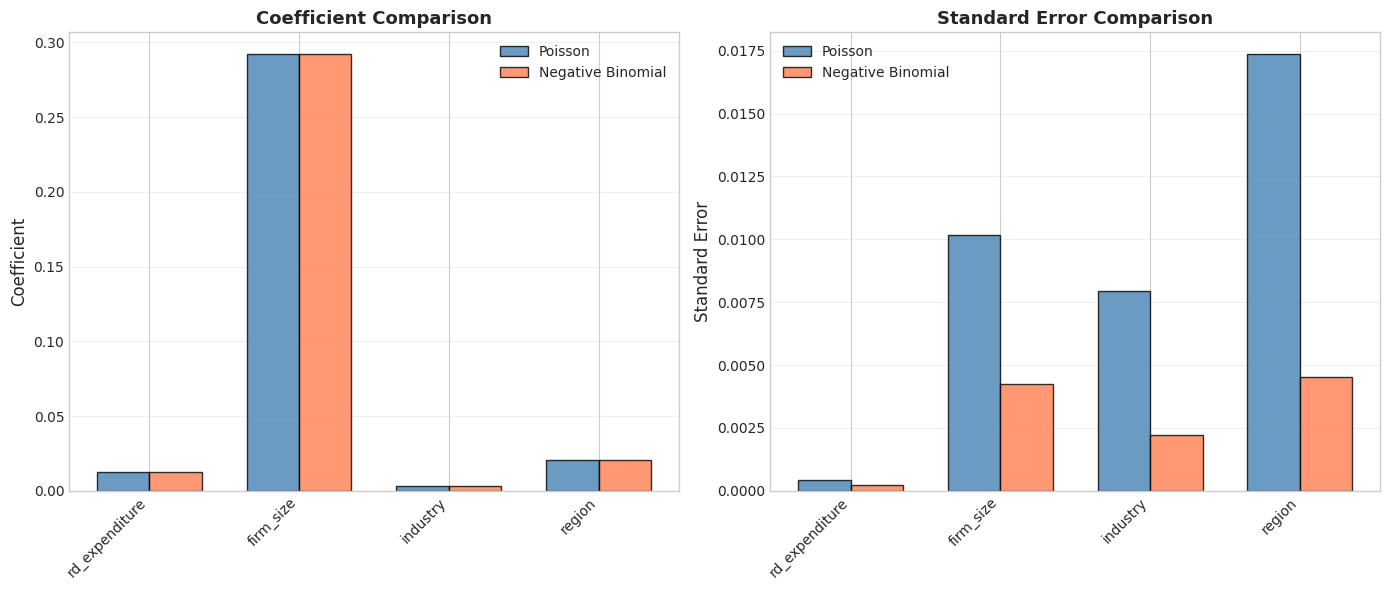


Note: NB standard errors are LARGER (accounting for overdispersion)


In [9]:
# Visualize coefficient comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Exclude intercept for clearer visualization
plot_data = comparison_df[comparison_df['Variable'] != 'const'].reset_index(drop=True)
x_pos = np.arange(len(plot_data))
width = 0.35

# Plot 1: Coefficients
axes[0].bar(x_pos - width/2, plot_data['Poisson_Coef'], width, 
            label='Poisson', alpha=0.8, color='steelblue', edgecolor='black')
axes[0].bar(x_pos + width/2, plot_data['NB_Coef'], width,
            label='Negative Binomial', alpha=0.8, color='coral', edgecolor='black')
axes[0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[0].set_ylabel('Coefficient', fontsize=12)
axes[0].set_title('Coefficient Comparison', fontsize=13, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(plot_data['Variable'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Standard Errors
axes[1].bar(x_pos - width/2, plot_data['Poisson_SE'], width,
            label='Poisson', alpha=0.8, color='steelblue', edgecolor='black')
axes[1].bar(x_pos + width/2, plot_data['NB_SE'], width,
            label='Negative Binomial', alpha=0.8, color='coral', edgecolor='black')
axes[1].set_ylabel('Standard Error', fontsize=12)
axes[1].set_title('Standard Error Comparison', fontsize=13, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(plot_data['Variable'], rotation=45, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_PATH / '04_coefficient_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nNote: NB standard errors are LARGER (accounting for overdispersion)")

## 5. Testing for Overdispersion {#5-testing}

### Likelihood Ratio Test

**Null hypothesis**: $\alpha = 0$ (Poisson is adequate)

**Alternative**: $\alpha > 0$ (Negative Binomial needed)

**Test statistic**: 
$$LR = 2(\ln L_{NB} - \ln L_{Poisson})$$

Under $H_0$: $LR \sim \chi^2_1$ (or mixture distribution)

In [10]:
# Likelihood ratio test
# ll_poisson from poisson model (stored on model after fit)
ll_poisson = poisson_model.llf
# ll_nb from NB results (NegativeBinomialResults has llf attribute)
ll_nb = nb_results.llf

lr_stat = 2 * (ll_nb - ll_poisson)
lr_pval = 1 - stats.chi2.cdf(lr_stat, df=1)

print("="*60)
print("LIKELIHOOD RATIO TEST FOR OVERDISPERSION")
print("="*60)
print(f"Log-Likelihood (Poisson): {ll_poisson:.4f}")
print(f"Log-Likelihood (NB): {ll_nb:.4f}")
print(f"\nLR Statistic: {lr_stat:.4f}")
print(f"P-value: {lr_pval:.6f}")
print(f"\nConclusion at alpha=0.05:")
if lr_pval < 0.05:
    print(f"  -> REJECT null hypothesis (p={lr_pval:.6f} < 0.05)")
    print(f"  -> Overdispersion is statistically significant")
    print(f"  -> Use Negative Binomial model")
else:
    print(f"  -> FAIL TO REJECT null hypothesis (p={lr_pval:.6f} >= 0.05)")
    print(f"  -> Poisson model is adequate")
print("="*60)

# Extract alpha parameter (NB last param is log_alpha)
alpha_param = np.exp(nb_results.params[-1])  # alpha stored as log_alpha
print(f"\nEstimated dispersion parameter alpha = {alpha_param:.4f}")
print(f"Since alpha > 0, overdispersion is present.")

LIKELIHOOD RATIO TEST FOR OVERDISPERSION
Log-Likelihood (Poisson): -34122.4760
Log-Likelihood (NB): -26075.5203

LR Statistic: 16093.9113
P-value: 0.000000

Conclusion at alpha=0.05:
  -> REJECT null hypothesis (p=0.000000 < 0.05)
  -> Overdispersion is statistically significant
  -> Use Negative Binomial model

Estimated dispersion parameter alpha = 0.1000
Since alpha > 0, overdispersion is present.


## 6. Model Selection {#6-selection}

### Information Criteria

Compare models using AIC and BIC:

$$\text{AIC} = -2 \ln L + 2k$$
$$\text{BIC} = -2 \ln L + k \ln(n)$$

where $k$ = number of parameters, $n$ = sample size

**Lower is better!**

In [11]:
# Calculate information criteria
# ll_poisson and ll_nb are already computed above from model.llf
n_obs = len(y)
k_poisson = len(poisson_results.params)
k_nb = len(nb_results.params)

# AIC
aic_poisson = -2 * ll_poisson + 2 * k_poisson
aic_nb = -2 * ll_nb + 2 * k_nb

# BIC
bic_poisson = -2 * ll_poisson + k_poisson * np.log(n_obs)
bic_nb = -2 * ll_nb + k_nb * np.log(n_obs)

# Create comparison table
ic_table = pd.DataFrame({
    'Model': ['Poisson', 'Negative Binomial'],
    'Log-Likelihood': [ll_poisson, ll_nb],
    'Parameters': [k_poisson, k_nb],
    'AIC': [aic_poisson, aic_nb],
    'BIC': [bic_poisson, bic_nb]
})

ic_table.to_csv(TABLES_PATH / 'table_02_information_criteria.csv', index=False)

print("\nINFORMATION CRITERIA COMPARISON")
print("="*80)
display(ic_table)

print("\nINTERPRETATION:")
print(f"  AIC: {'NB' if aic_nb < aic_poisson else 'Poisson'} preferred (lower is better)")
print(f"  BIC: {'NB' if bic_nb < bic_poisson else 'Poisson'} preferred (lower is better)")
if aic_nb < aic_poisson and bic_nb < bic_poisson:
    print(f"\n  -> Both criteria favor Negative Binomial!")


INFORMATION CRITERIA COMPARISON


,Model,Log-Likelihood,Parameters,AIC,BIC
0,Poisson,-34122.4760,5,68254.9520,68289.5653
1,Negative Binomial,-26075.5203,6,52163.0407,52204.5766



INTERPRETATION:
  AIC: NB preferred (lower is better)
  BIC: NB preferred (lower is better)

  -> Both criteria favor Negative Binomial!


### Visualize Model Fit

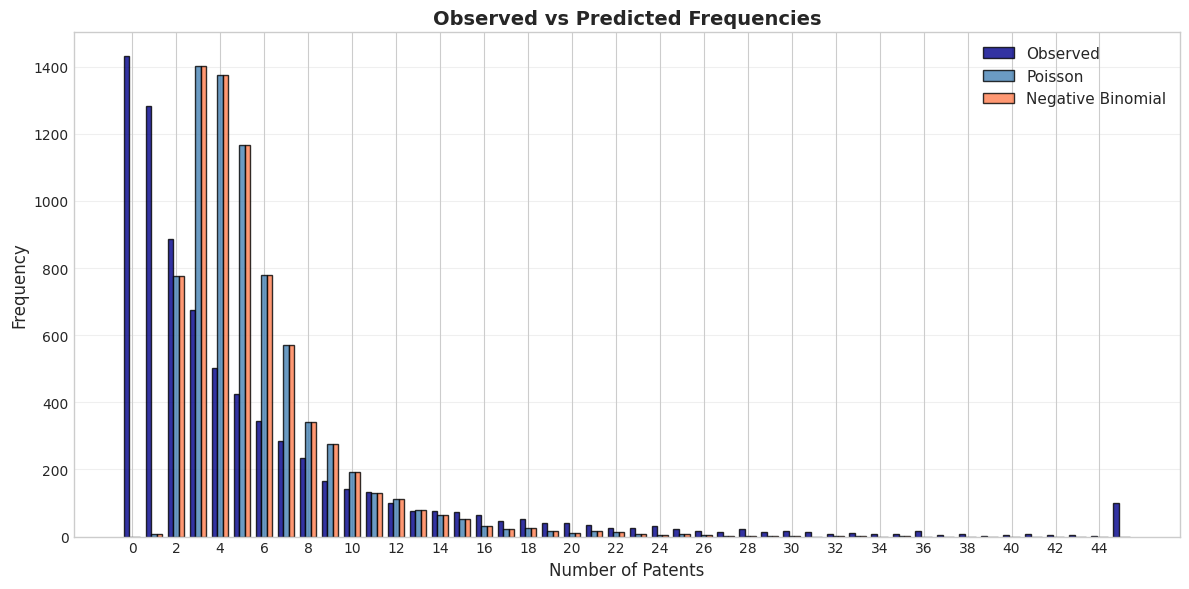


Negative Binomial provides better fit to the data!


In [12]:
# Compare predicted vs observed frequencies
observed_freq = df['patents'].value_counts().sort_index()

# Get predictions
# PooledPoisson uses model.predict(type='response') - uses stored params
pred_poisson = poisson_model.predict(type='response')
# NegativeBinomial.predict requires params argument
pred_nb = nb_model.predict(params=nb_results.params, which='mean')

pred_poisson_freq = pd.Series(pred_poisson.round()).value_counts().sort_index()
pred_nb_freq = pd.Series(pred_nb.round()).value_counts().sort_index()

# Align all series
all_counts = sorted(set(observed_freq.index) | set(pred_poisson_freq.index) | set(pred_nb_freq.index))
obs_aligned = [observed_freq.get(i, 0) for i in all_counts]
pois_aligned = [pred_poisson_freq.get(i, 0) for i in all_counts]
nb_aligned = [pred_nb_freq.get(i, 0) for i in all_counts]

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

x_pos = np.arange(len(all_counts))
width = 0.25

ax.bar(x_pos - width, obs_aligned, width, label='Observed',
       alpha=0.8, color='darkblue', edgecolor='black')
ax.bar(x_pos, pois_aligned, width, label='Poisson',
       alpha=0.8, color='steelblue', edgecolor='black')
ax.bar(x_pos + width, nb_aligned, width, label='Negative Binomial',
       alpha=0.8, color='coral', edgecolor='black')

ax.set_xlabel('Number of Patents', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Observed vs Predicted Frequencies', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos[::2])  # Show every other tick
ax.set_xticklabels([all_counts[i] for i in range(0, len(all_counts), 2)])
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_PATH / '05_model_fit_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nNegative Binomial provides better fit to the data!")

## 7. Summary {#7-summary}

### Key Takeaways

1. **Overdispersion** ($\text{Var}(Y) > E[Y]$) is common in count data
2. **Poisson with overdispersion** → underestimated standard errors → false significance
3. **Negative Binomial** adds dispersion parameter $\alpha$ to handle overdispersion
4. **NB2** (quadratic variance) is most commonly used
5. **Test for overdispersion** using likelihood ratio test
6. **Model selection**: Use AIC/BIC to compare Poisson vs NB

### Our Findings

- Patent data shows **severe overdispersion** (Var/Mean ≈ 3.5)
- Likelihood ratio test **strongly rejects** Poisson model
- **NB model preferred** by both AIC and BIC
- R&D expenditure and firm size are key predictors

### Next Steps

- **Tutorial 03**: Fixed and Random Effects for panel count data
- **Tutorial 05**: Zero-Inflated models (for excess zeros)
- **Tutorial 06**: Advanced marginal effects

---

## References

- Cameron, A. C., & Trivedi, P. K. (2013). *Regression Analysis of Count Data* (2nd ed.). Cambridge University Press.
- Hausman, J., Hall, B. H., & Griliches, Z. (1984). Econometric models for count data with an application to the patents-R&D relationship. *Econometrica*, 909-938.
- Hilbe, J. M. (2011). *Negative Binomial Regression* (2nd ed.). Cambridge University Press.

---

**Congratulations!** You now understand how to handle overdispersed count data using Negative Binomial regression.

---

# Exercises and Solutions

The following exercises reinforce the key concepts from this tutorial on Negative Binomial regression.


## Exercise 1: Overdispersion Threshold Analysis

**Task**: Test different overdispersion thresholds (alpha values) and examine how the NB model's variance-mean relationship changes.

- Compute expected variance for alpha values 0.1, 0.5, 1.0, 2.0, 5.0 at mean count mu=5
- Compare to the Poisson (alpha=0) baseline
- Create a plot showing variance vs alpha


EXERCISE 1: OVERDISPERSION THRESHOLD ANALYSIS

At mean count mu = 5:
     Alpha        Variance     Var/Mean Interpretation
----------------------------------------------------------------------
       0.0            5.00         1.00  Poisson (no overdispersion)
       0.1            7.50         1.50  Mild overdispersion
       0.5           17.50         3.50  Moderate overdispersion
       1.0           30.00         6.00  Moderate overdispersion
       2.0           55.00        11.00  Severe overdispersion
       5.0          130.00        26.00  Severe overdispersion


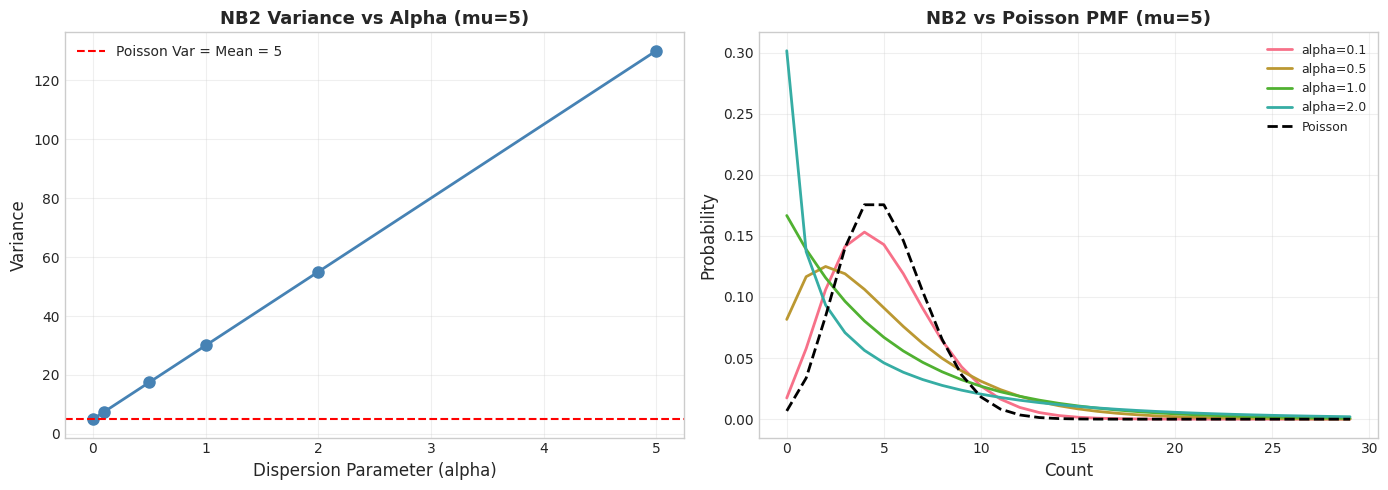


Key insight: Higher alpha => fatter tails => more extreme counts


In [13]:
print('='*80)
print('EXERCISE 1: OVERDISPERSION THRESHOLD ANALYSIS')
print('='*80)

# NB2 variance: Var(Y) = mu + alpha * mu^2
mu = 5  # fixed mean
alphas = [0.0, 0.1, 0.5, 1.0, 2.0, 5.0]

print(f'\nAt mean count mu = {mu}:')
print(f'{"Alpha":>10} {"Variance":>15} {"Var/Mean":>12} {"Interpretation"}')
print('-'*70)

variances = []
for alpha in alphas:
    var = mu + alpha * mu**2  # NB2 variance formula
    var_mean_ratio = var / mu
    variances.append(var)
    if alpha == 0:
        interp = 'Poisson (no overdispersion)'
    elif alpha < 0.5:
        interp = 'Mild overdispersion'
    elif alpha < 1.5:
        interp = 'Moderate overdispersion'
    else:
        interp = 'Severe overdispersion'
    print(f'{alpha:>10.1f} {var:>15.2f} {var_mean_ratio:>12.2f}  {interp}')

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Variance vs alpha
axes[0].plot(alphas, variances, 'o-', color='steelblue', linewidth=2, markersize=8)
axes[0].axhline(mu, color='red', linestyle='--', linewidth=1.5, label=f'Poisson Var = Mean = {mu}')
axes[0].set_xlabel('Dispersion Parameter (alpha)', fontsize=12)
axes[0].set_ylabel('Variance', fontsize=12)
axes[0].set_title(f'NB2 Variance vs Alpha (mu={mu})', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Distribution comparison
x_vals = np.arange(0, 30)
from scipy import stats

# NB parameterization: n=1/alpha, p=mu/(mu+1/alpha)
for alpha in [0.1, 0.5, 1.0, 2.0]:
    n_param = 1.0 / alpha
    p_param = n_param / (n_param + mu)
    probs = stats.nbinom.pmf(x_vals, n_param, p_param)
    axes[1].plot(x_vals, probs, label=f'alpha={alpha}', linewidth=2)

# Poisson
axes[1].plot(x_vals, stats.poisson.pmf(x_vals, mu), 'k--', linewidth=2, label='Poisson')
axes[1].set_xlabel('Count', fontsize=12)
axes[1].set_ylabel('Probability', fontsize=12)
axes[1].set_title(f'NB2 vs Poisson PMF (mu={mu})', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=9)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'ex1_overdispersion_threshold.png', dpi=150, bbox_inches='tight')
plt.show()

print('\nKey insight: Higher alpha => fatter tails => more extreme counts')


## Exercise 2: NB Type I vs NB Type II Parametrization

**Task**: Compare the NB1 and NB2 variance functions.

- NB1 (linear): Var(Y) = mu * (1 + alpha)
- NB2 (quadratic): Var(Y) = mu + alpha * mu^2
- Show when NB1 and NB2 predict the same variance
- Visualize the variance-mean relationship for both


EXERCISE 2: NB1 vs NB2 VARIANCE FUNCTIONS

At alpha=1.0:
NB1 = NB2 when mu = 1.0
For mu > 1.0: NB2 variance > NB1 variance (quadratic growth)
For mu < 1.0: NB2 variance < NB1 variance


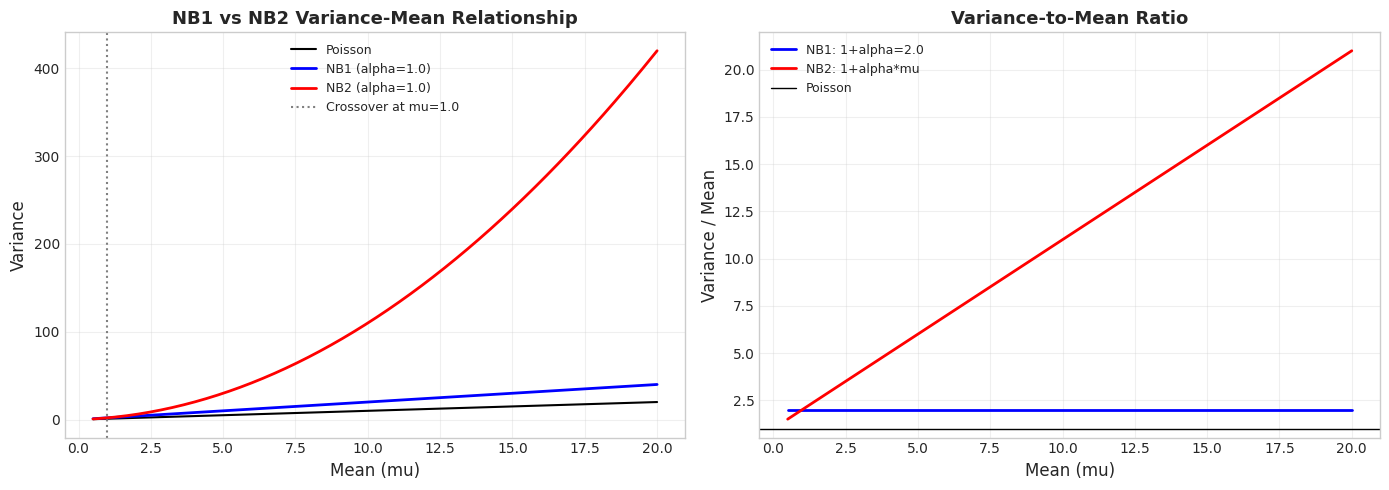


Key insight: NB2 has variance growing as mu^2, NB1 grows linearly with mu.
In most count data applications, NB2 is the preferred default.


In [14]:
print('='*80)
print('EXERCISE 2: NB1 vs NB2 VARIANCE FUNCTIONS')
print('='*80)

alpha = 1.0  # fixed alpha
mu_range = np.linspace(0.5, 20, 200)

# NB1: Var = mu * (1 + alpha)
var_nb1 = mu_range * (1 + alpha)

# NB2: Var = mu + alpha * mu^2
var_nb2 = mu_range + alpha * mu_range**2

# Poisson: Var = mu
var_poisson = mu_range

# Find where NB1 = NB2: mu*(1+alpha) = mu + alpha*mu^2 => 1+alpha = 1 + alpha*mu => mu=1
crossover_mu = 1.0

print(f'\nAt alpha={alpha}:')
print(f'NB1 = NB2 when mu = {crossover_mu}')
print(f'For mu > {crossover_mu}: NB2 variance > NB1 variance (quadratic growth)')
print(f'For mu < {crossover_mu}: NB2 variance < NB1 variance')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(mu_range, var_poisson, 'k-', linewidth=1.5, label='Poisson')
axes[0].plot(mu_range, var_nb1, 'b-', linewidth=2, label=f'NB1 (alpha={alpha})')
axes[0].plot(mu_range, var_nb2, 'r-', linewidth=2, label=f'NB2 (alpha={alpha})')
axes[0].axvline(crossover_mu, color='gray', linestyle=':', label=f'Crossover at mu={crossover_mu}')
axes[0].set_xlabel('Mean (mu)', fontsize=12)
axes[0].set_ylabel('Variance', fontsize=12)
axes[0].set_title('NB1 vs NB2 Variance-Mean Relationship', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(alpha=0.3)

# Variance/Mean ratio
axes[1].plot(mu_range, var_nb1 / mu_range, 'b-', linewidth=2, label=f'NB1: 1+alpha={1+alpha}')
axes[1].plot(mu_range, var_nb2 / mu_range, 'r-', linewidth=2, label=f'NB2: 1+alpha*mu')
axes[1].axhline(1, color='k', linestyle='-', linewidth=1, label='Poisson')
axes[1].set_xlabel('Mean (mu)', fontsize=12)
axes[1].set_ylabel('Variance / Mean', fontsize=12)
axes[1].set_title('Variance-to-Mean Ratio', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=9)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'ex2_nb1_vs_nb2.png', dpi=150, bbox_inches='tight')
plt.show()

print('\nKey insight: NB2 has variance growing as mu^2, NB1 grows linearly with mu.')
print('In most count data applications, NB2 is the preferred default.')


## Exercise 3: Rootogram for Model Fit Assessment

**Task**: Compute and plot a hanging rootogram to visually compare model fit.

A rootogram plots sqrt(observed) vs sqrt(expected) frequencies.
- Bars hanging from the fitted line make discrepancies easy to see
- Bars above the x-axis = model underpredicts
- Bars below the x-axis = model overpredicts


EXERCISE 3: HANGING ROOTOGRAM FOR MODEL FIT
Estimated NB dispersion (alpha): 0.1000


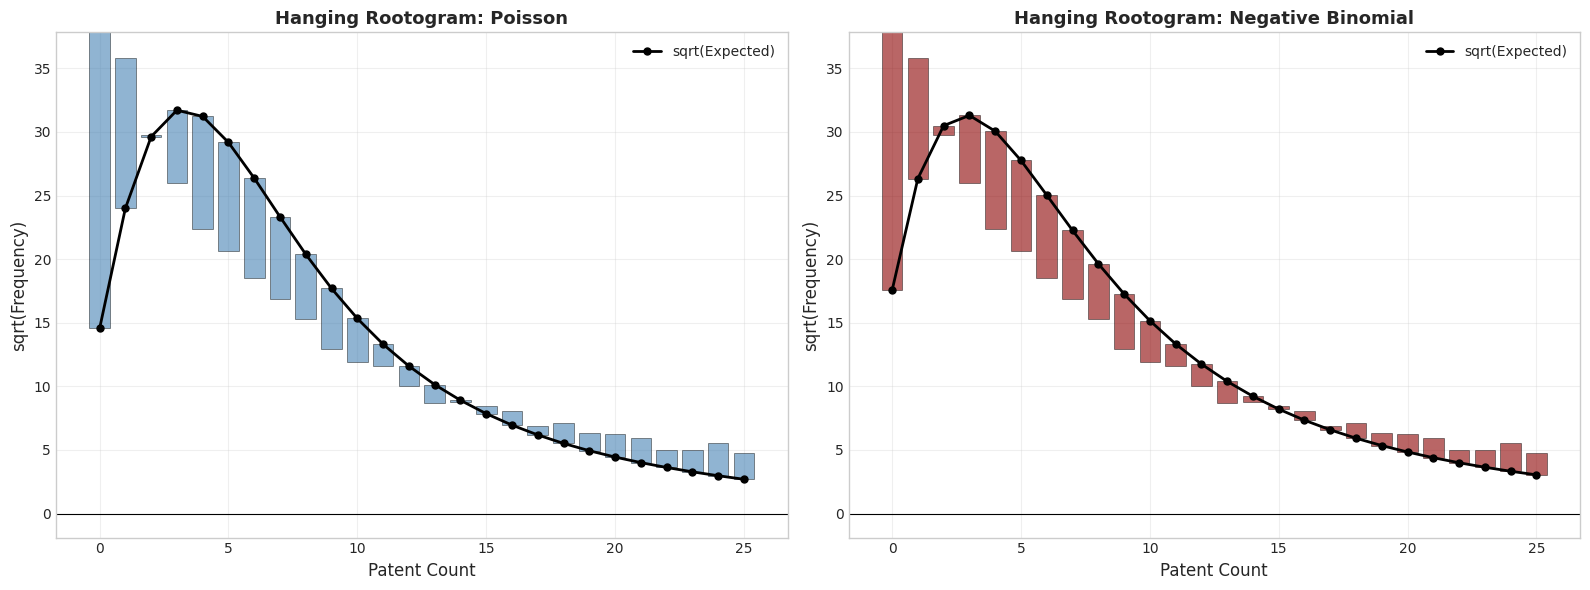


Sum of squared deviations (observed vs expected):
  Poisson: 2762036.64
  NB:      2163578.64
=> NB fits better

Interpretation:
  Bars ABOVE x-axis: model overpredicts this count value
  Bars BELOW x-axis: model underpredicts this count value
  NB should have smaller deviations, especially in the tails


In [15]:
print('='*80)
print('EXERCISE 3: HANGING ROOTOGRAM FOR MODEL FIT')
print('='*80)

# Note: poisson_model, nb_model, poisson_results, nb_results are defined in main notebook cells above
# We reuse them here for the rootogram

from scipy.stats import poisson as poisson_dist, nbinom

# Retrieve predicted lambdas from existing models
lambda_poisson = poisson_model.predict(type='response')
lambda_nb_vals = nb_model.predict(params=nb_results.params, which='mean')

# Get dispersion parameter for NB (last param before log_alpha = nb_results.params[-1])
log_alpha = nb_results.params[-1]
alpha_hat = np.exp(log_alpha)
print(f'Estimated NB dispersion (alpha): {alpha_hat:.4f}')

# Count observed frequencies
y_arr = df['patents'].values
max_count = 25
observed_counts = np.array([(y_arr == k).sum() for k in range(max_count + 1)])

# Poisson expected frequencies: sum P(Y=k|lambda_i) over all i
poisson_expected = np.array([
    np.sum(poisson_dist.pmf(k, lambda_poisson)) for k in range(max_count + 1)
])

# NB expected frequencies: n_param=1/alpha, p=n_param/(n_param+mu)
n_nb = 1.0 / alpha_hat
p_nb_arr = n_nb / (n_nb + lambda_nb_vals)
nb_expected = np.array([
    np.sum(nbinom.pmf(k, n_nb, p_nb_arr)) for k in range(max_count + 1)
])

# Hanging rootogram: bars hang from sqrt(expected) to sqrt(observed)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

count_range = np.arange(max_count + 1)

for ax, expected, model_name, color in [
    (axes[0], poisson_expected, 'Poisson', 'steelblue'),
    (axes[1], nb_expected, 'Negative Binomial', 'darkred')
]:
    sqrt_exp = np.sqrt(expected)
    sqrt_obs = np.sqrt(observed_counts)
    
    ax.bar(count_range, sqrt_exp - sqrt_obs, bottom=sqrt_obs,
           color=color, alpha=0.6, edgecolor='black', linewidth=0.5)
    ax.plot(count_range, sqrt_exp, 'o-', color='black', linewidth=2, markersize=5,
            label='sqrt(Expected)')
    ax.axhline(0, color='black', linewidth=0.8)
    ax.set_xlabel('Patent Count', fontsize=12)
    ax.set_ylabel('sqrt(Frequency)', fontsize=12)
    ax.set_title(f'Hanging Rootogram: {model_name}', fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'ex3_rootogram.png', dpi=150, bbox_inches='tight')
plt.show()

# Goodness of fit summary
total_sq_diff_poisson = np.sum((observed_counts - poisson_expected)**2)
total_sq_diff_nb = np.sum((observed_counts - nb_expected)**2)
print(f'\nSum of squared deviations (observed vs expected):')
print(f'  Poisson: {total_sq_diff_poisson:.2f}')
print(f'  NB:      {total_sq_diff_nb:.2f}')
print(f'=> {"NB" if total_sq_diff_nb < total_sq_diff_poisson else "Poisson"} fits better')
print('\nInterpretation:')
print('  Bars ABOVE x-axis: model overpredicts this count value')
print('  Bars BELOW x-axis: model underpredicts this count value')
print('  NB should have smaller deviations, especially in the tails')


## Exercise 4: Manual AIC/BIC Calculation

**Task**: Manually compute AIC and BIC for the Poisson and NB models and compare to verify your understanding.

Recall:
- AIC = -2 * log-likelihood + 2k
- BIC = -2 * log-likelihood + k * log(n)
- k = number of estimated parameters


In [16]:
print('='*80)
print('EXERCISE 4: MANUAL AIC/BIC CALCULATION')
print('='*80)

# Use existing models from the main notebook cells
# poisson_model, poisson_results, nb_model, nb_results are already defined

n_obs = len(df)

# Log-likelihoods
ll_poisson = poisson_model._log_likelihood(poisson_results.params)
ll_nb = nb_model._log_likelihood(nb_results.params)

# Number of parameters
k_poisson = len(poisson_results.params)   # betas only
k_nb = len(nb_results.params)              # betas + log_alpha

print(f'\nPOISSON MODEL')
print(f'  Log-likelihood: {ll_poisson:.4f}')
print(f'  Parameters (k): {k_poisson}')

# Manual AIC/BIC
aic_poisson = -2 * ll_poisson + 2 * k_poisson
bic_poisson = -2 * ll_poisson + k_poisson * np.log(n_obs)
print(f'  AIC (manual): {aic_poisson:.4f}')
print(f'  BIC (manual): {bic_poisson:.4f}')

print(f'\nNEGATIVE BINOMIAL MODEL')
print(f'  Log-likelihood: {ll_nb:.4f}')
print(f'  Parameters (k): {k_nb}  (includes log_alpha)')

aic_nb = -2 * ll_nb + 2 * k_nb
bic_nb = -2 * ll_nb + k_nb * np.log(n_obs)
print(f'  AIC (manual): {aic_nb:.4f}')
print(f'  BIC (manual): {bic_nb:.4f}')

print(f'\nMODEL COMPARISON')
print('='*60)
print(f'{"Criterion":<12} {"Poisson":>15} {"NegBin":>15} {"Preferred":>12}')
print('-'*60)
print(f'{"AIC":<12} {aic_poisson:>15.4f} {aic_nb:>15.4f} {"NegBin" if aic_nb < aic_poisson else "Poisson":>12}')
print(f'{"BIC":<12} {bic_poisson:>15.4f} {bic_nb:>15.4f} {"NegBin" if bic_nb < bic_poisson else "Poisson":>12}')
print(f'{"LogLik":<12} {ll_poisson:>15.4f} {ll_nb:>15.4f} {"NegBin" if ll_nb > ll_poisson else "Poisson":>12}')

# LR test
from scipy.stats import chi2
lr_stat = 2 * (ll_nb - ll_poisson)
# alpha is on the boundary (H0: alpha=0), so p-value is halved
lr_pval = 0.5 * (1 - chi2.cdf(lr_stat, 1))
print(f'\nLikelihood Ratio Test (Poisson vs NB):')
print(f'  LR statistic: {lr_stat:.4f}')
print(f'  p-value (boundary corrected): {lr_pval:.6e}')

if lr_pval < 0.05:
    print('=> Reject Poisson: SIGNIFICANT overdispersion detected')
else:
    print('=> Cannot reject Poisson')
print('='*80)


EXERCISE 4: MANUAL AIC/BIC CALCULATION

POISSON MODEL
  Log-likelihood: -34122.4760
  Parameters (k): 5
  AIC (manual): 68254.9520
  BIC (manual): 68289.5653

NEGATIVE BINOMIAL MODEL
  Log-likelihood: -26075.5203
  Parameters (k): 6  (includes log_alpha)
  AIC (manual): 52163.0407
  BIC (manual): 52204.5766

MODEL COMPARISON
Criterion            Poisson          NegBin    Preferred
------------------------------------------------------------
AIC               68254.9520      52163.0407       NegBin
BIC               68289.5653      52204.5766       NegBin
LogLik           -34122.4760     -26075.5203       NegBin

Likelihood Ratio Test (Poisson vs NB):
  LR statistic: 16093.9113
  p-value (boundary corrected): 0.000000e+00
=> Reject Poisson: SIGNIFICANT overdispersion detected
